# Импортирование библиотек

In [1]:
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import numpy as np
import numpy.ma as ma

import pyproj

from scipy import stats as st
from scipy.stats.mstats import gmean, hmean
from scipy.io import loadmat
from sklearn.metrics import classification_report, accuracy_score

import geopandas as gpd
import pandas as pd
import fiona
from fiona.drvsupport import supported_drivers
from shapely.geometry import Polygon
from shapely.ops import unary_union

from matplotlib.colors import ListedColormap
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.path import Path
import pylab as plt

import seaborn as sns
import cv2

np.seterr(divide='ignore', invalid='ignore')

colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']

## Загрузка реальных данных о пастбище в формате .jp2
## дата: 2022/08/28

In [2]:
bands = glob("./Pasture_Images/dates/20220828/*B?*.jp2")
if (not bands):
    bands = glob("./Pasture_Images/dates/20220828/*B?*.tif")
bands.sort()
for i, band in enumerate(bands):
    print("Номер:", i, "Канал:", band[-7:-4])

Номер: 0 Канал: B01
Номер: 1 Канал: B02
Номер: 2 Канал: B03
Номер: 3 Канал: B04
Номер: 4 Канал: B05
Номер: 5 Канал: B06
Номер: 6 Канал: B07
Номер: 7 Канал: B08
Номер: 8 Канал: B09
Номер: 9 Канал: B10
Номер: 10 Канал: B11
Номер: 11 Канал: B12
Номер: 12 Канал: B8A


# Формирование стэка (3-х мерной матрицы) изображении

In [3]:
layers = []
for band in bands:
  with rio.open(band, 'r') as file_image:
    layers.append(file_image.read(1))

In [4]:
sorter = lambda x: len(x)
sorted_layers = sorted(layers, key=sorter, reverse=True)
largest_dimension = len(sorted_layers[0])
smallest_dimension = len(sorted_layers[-1])

### Разбивка изображении (приведение в один размер) 

In [5]:
try:
    bands_stack = np.stack(layers)
except:
    reshaped_layer = []
    for layer in layers:
        if (layer.shape[0] < largest_dimension or layer.shape[1] < largest_dimension):
            new_layer = cv2.resize(layer, dsize=(largest_dimension, largest_dimension), interpolation=cv2.INTER_CUBIC)
            reshaped_layer.append(new_layer)
        else:
            reshaped_layer.append(layer)
    bands_stack = np.stack(reshaped_layer)

### 10980 x 10980 Размер изображения с разширением в 10м на пиксель

In [6]:
image_width, image_height = bands_stack.shape[1], bands_stack.shape[2]

# Обрезка изображении по GPS координатам

In [7]:
supported_drivers['KML'] = 'rw'

pasture_df = gpd.read_file('pasture.kml', driver='KML').to_crs("EPSG:32642")
global_df = gpd.read_file('global.kml', driver='KML').to_crs("EPSG:32642")

T42UWF = global_df[global_df["Name"] == "42UWF"].reset_index(0, True)
T42UWF = T42UWF.iloc[0]

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_3676\3936315179.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.reset_index except for the argument 'level' will be keyword-only.
  T42UWF = global_df[global_df["Name"] == "42UWF"].reset_index(0, True)


In [8]:
all_zagons = []
for zagon in range(len(pasture_df.index)):
    all_zagons.append(pasture_df.loc[zagon].geometry)

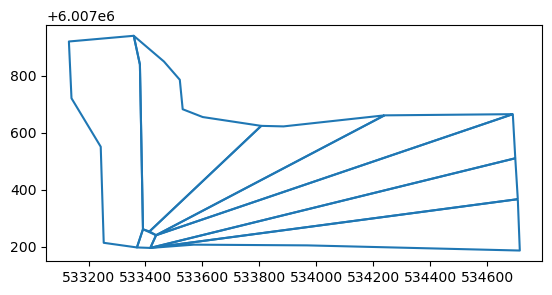

In [9]:
gpd.GeoSeries(all_zagons).boundary.plot()
plt.show()

In [10]:
merged_zagons = unary_union(all_zagons)

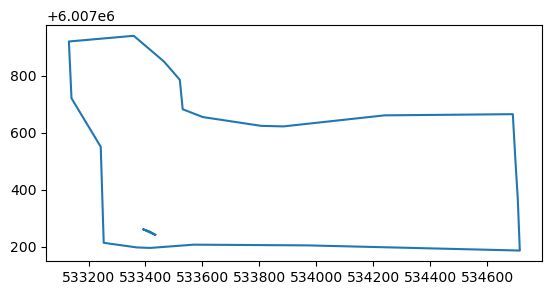

In [11]:
gpd.GeoSeries([merged_zagons]).boundary.plot()
plt.show()

### Крайние точки пастбища и глобального квадрата (мозайки)

In [12]:
x_min, y_min, x_max, y_max = merged_zagons.bounds 
X_min, Y_min, X_max, Y_max = T42UWF.geometry.bounds

# Конвертация

In [13]:
dim_size = bands_stack.shape[1]
x_axis_cut1 = int(np.interp(x_min, [X_min, X_max], [0, dim_size])) # Левая грань
x_axis_cut2 = int(np.interp(x_max, [X_min, X_max], [0, dim_size])) # Правая грань
y_axis_cut1 = int(np.interp(y_max, [Y_min, Y_max], [dim_size, 0])) # Нижняя грань
y_axis_cut2 = int(np.interp(y_min, [Y_min, Y_max], [dim_size, 0])) # Вверняя грань

print(x_axis_cut1, x_axis_cut2, x_axis_cut1 - x_axis_cut2)
print(y_axis_cut1, y_axis_cut2, y_axis_cut1 - y_axis_cut2)

3315 3473 -158
9207 9283 -76


# Вывод изображения-обрезки пастбища 

### aoi - (area of interest) = Область интереса (пастбище)

In [14]:
aoi_bands_stack = bands_stack[:, y_axis_cut1:y_axis_cut2, x_axis_cut1:x_axis_cut2]

# Все 13 каналов

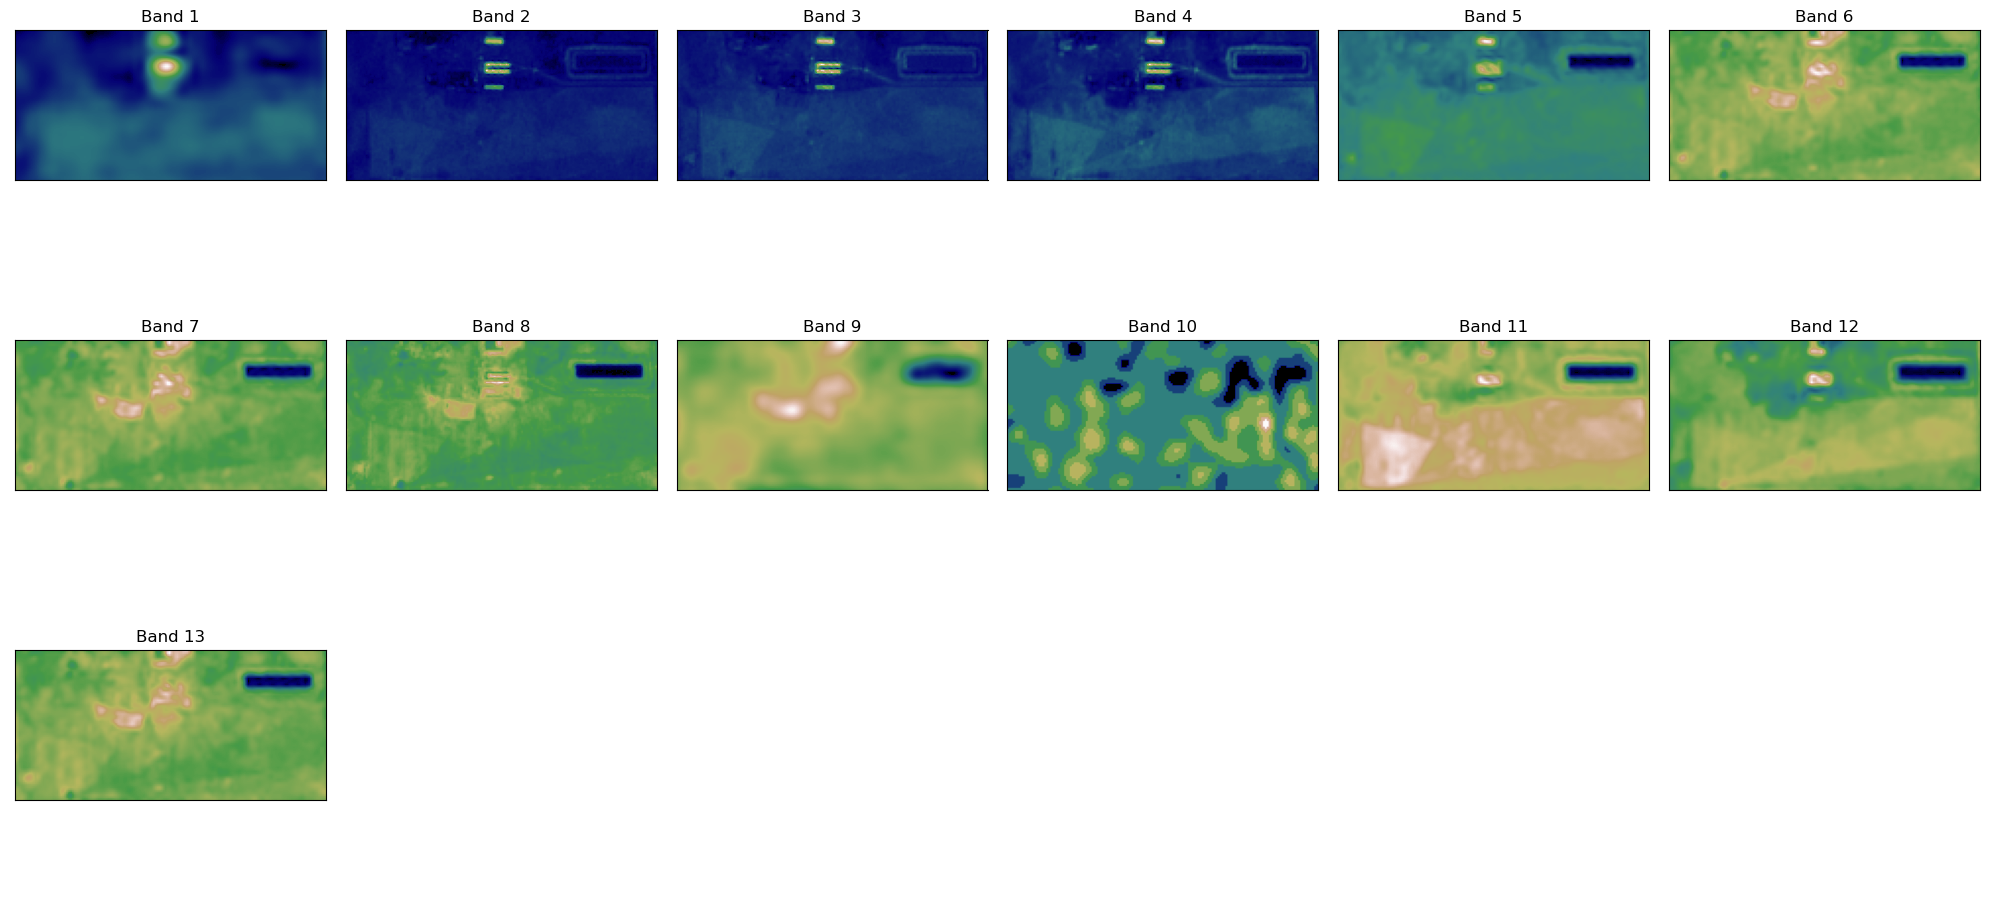

In [15]:
ep.plot_bands(aoi_bands_stack, 
              cmap = 'gist_earth', 
              figsize = (20, 10), 
              cols = 6, 
              cbar = False)
plt.show()

# Реальное RGB изображение пастбища без коррекции

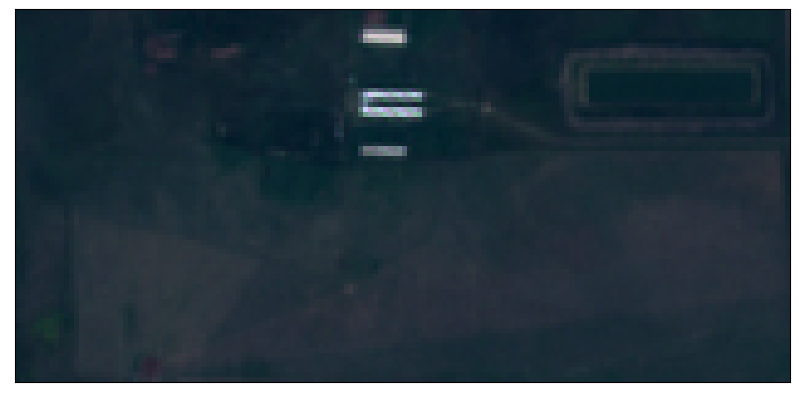

In [16]:
rgb = ep.plot_rgb(aoi_bands_stack, 
                  rgb=(3,2,1), 
                  figsize=(10, 16))
plt.show()

# Реальное RGB изображение пастбища с коррекцией

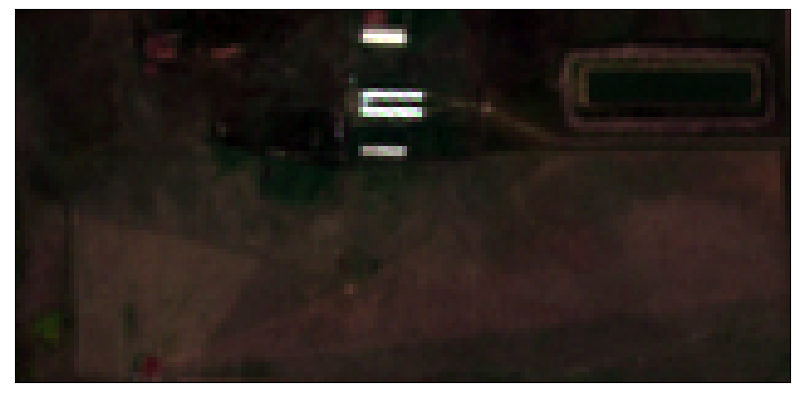

In [17]:
ep.plot_rgb(aoi_bands_stack,
            rgb=(3, 2, 1),
            stretch=True,
            str_clip=0.2,
            figsize=(10, 16))
plt.show()

# Создание масок для загонов

In [18]:
aoi_width, aoi_height = aoi_bands_stack.shape[2], aoi_bands_stack.shape[1]

In [19]:
masks = []
for zagon in range(len(pasture_df)-1):
    polygon=[]

    for coords in pasture_df.loc[zagon].geometry.exterior.coords:

        x = int(np.interp(coords[0], [x_min, x_max], [0, aoi_width]))
        y = int(np.interp(coords[1], [y_min, y_max], [aoi_height, 0]))

        polygon.append((y, x))

    poly_path=Path(polygon)
    x, y = np.mgrid[:aoi_height, :aoi_width]
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # coors.shape is (4000000,2)

    mask = ~poly_path.contains_points(coors)
    masks.append(mask)

# Пример одной маски для определенного загона

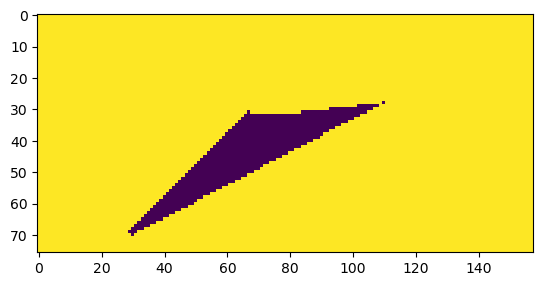

In [21]:
plt.imshow(masks[2].reshape(aoi_height, aoi_width))
plt.show()

# Normalized Difference Vegetation Index (NDVI)

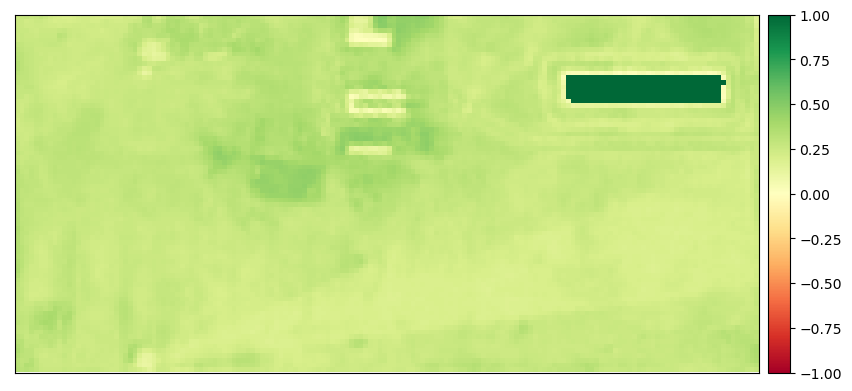

In [22]:
ndvi = es.normalized_diff(aoi_bands_stack[7], aoi_bands_stack[3])
ep.plot_bands(ndvi, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))

plt.show()

In [23]:
ndvi_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(ndvi, mask=mask.reshape(aoi_height, aoi_width))
    ndvi_masked_array.append(mx)

# Гистограмма NDVI по загонам

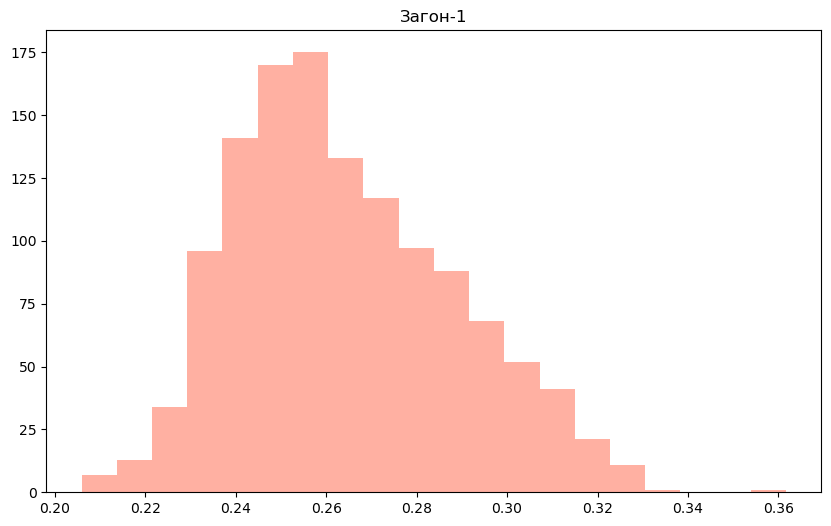

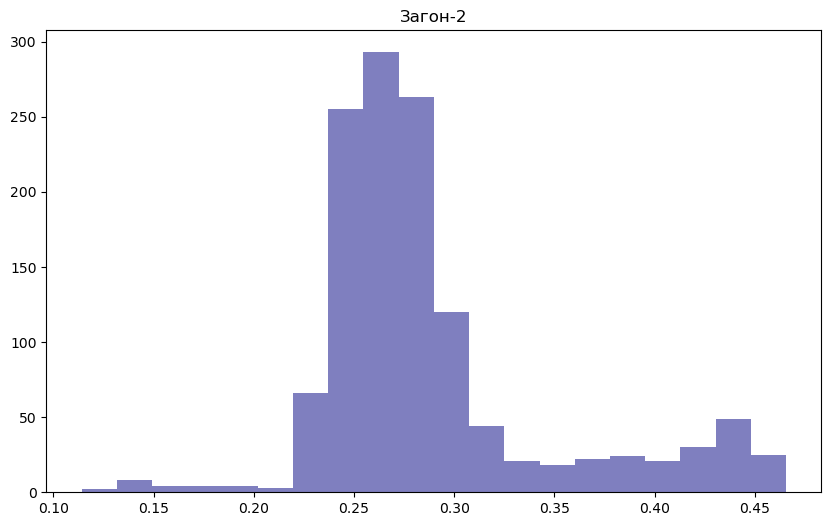

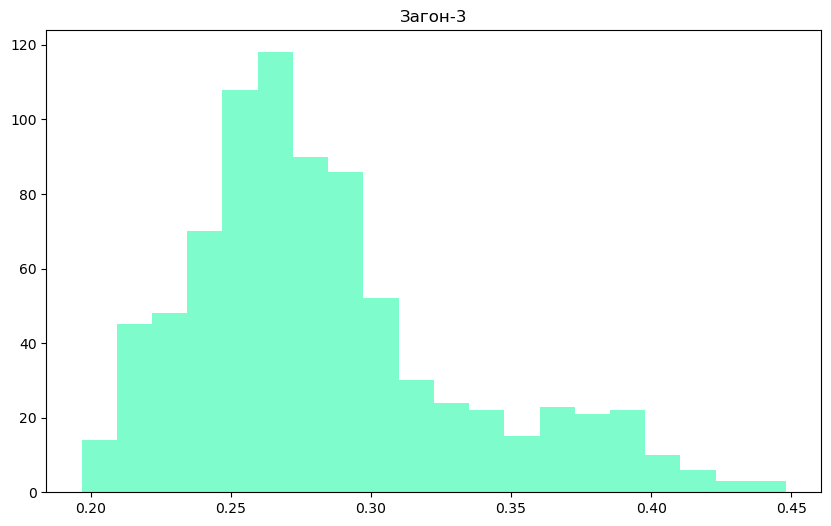

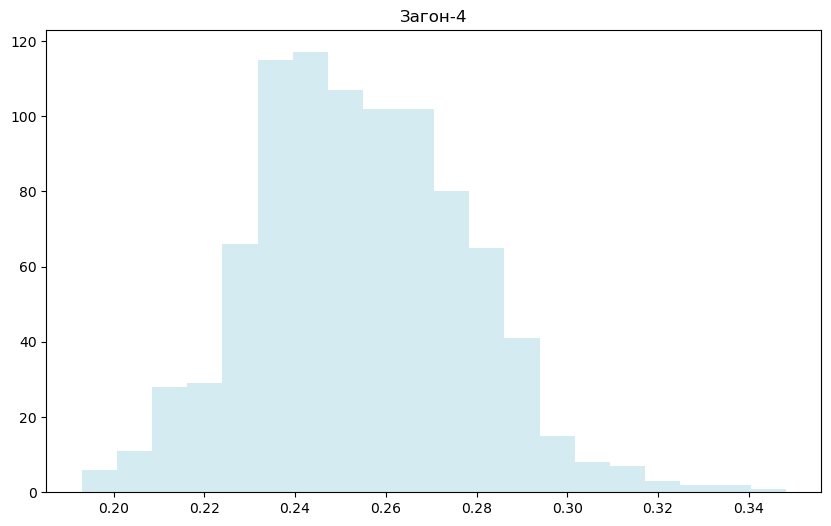

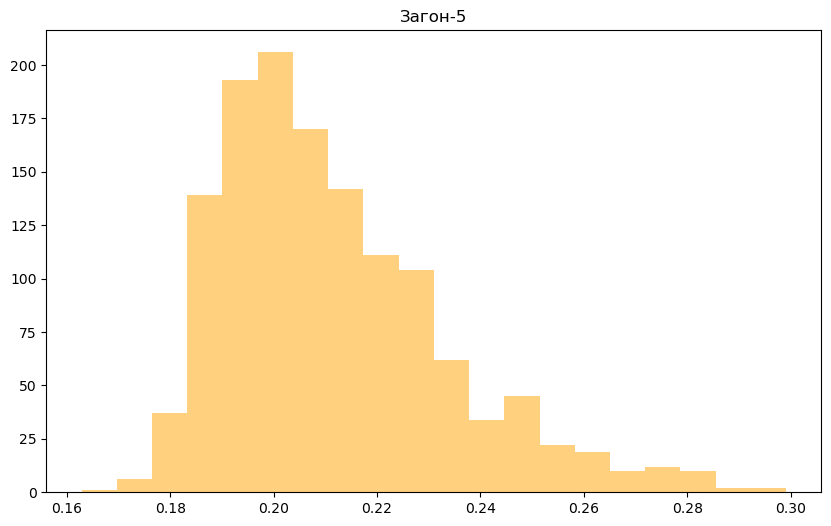

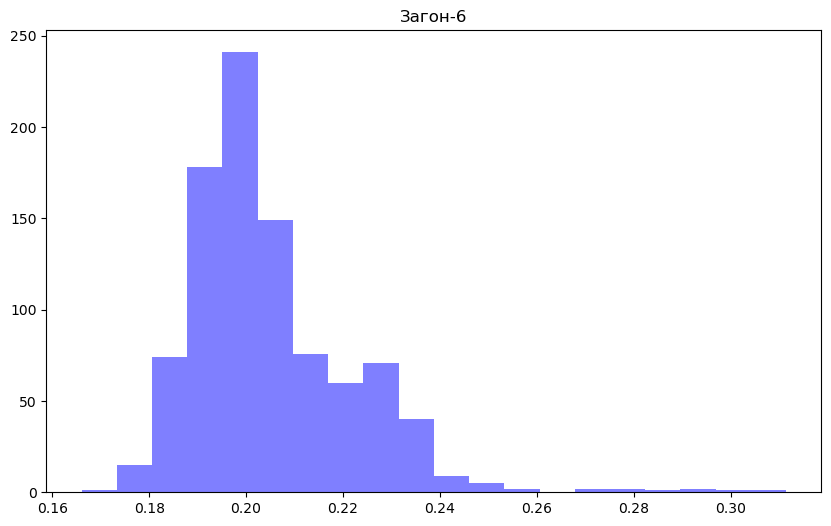

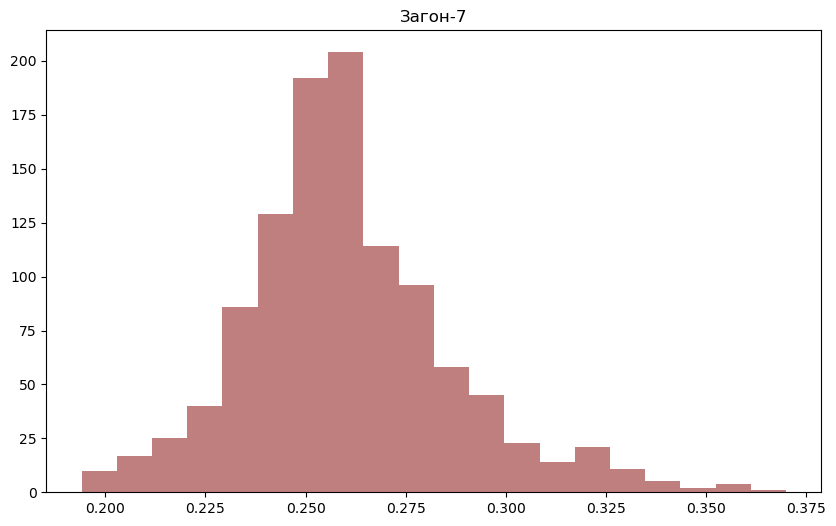

In [24]:
for i, zagon in enumerate(ndvi_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))

plt.show()

# Статистические средние значения по загонам 

In [25]:
for zagon in range(len(masks)):
    print(f"Загон №{zagon+1}. Среднее значение NDVI: ", ndvi_masked_array[zagon].mean())

Загон №1. Среднее значение NDVI:  0.26427697634502023
Загон №2. Среднее значение NDVI:  0.2880399859069631
Загон №3. Среднее значение NDVI:  0.2833987696435947
Загон №4. Среднее значение NDVI:  0.25447180600424996
Загон №5. Среднее значение NDVI:  0.21141422593743253
Загон №6. Среднее значение NDVI:  0.20495511017401835
Загон №7. Среднее значение NDVI:  0.26038534551018455


In [26]:
for zagon in range(len(masks)):
    print(f"Загон №{zagon+1}. Медианное значение NDVI: ", ma.median(ndvi_masked_array[zagon]))

Загон №1. Медианное значение NDVI:  0.2602896785757557
Загон №2. Медианное значение NDVI:  0.2721604304076204
Загон №3. Медианное значение NDVI:  0.272480266140066
Загон №4. Медианное значение NDVI:  0.25322245322245324
Загон №5. Медианное значение NDVI:  0.2066321243523316
Загон №6. Медианное значение NDVI:  0.20092303707226172
Загон №7. Медианное значение NDVI:  0.25790492579049257


In [27]:
for zagon in range(len(masks)):
    print(f"Загон №{zagon+1}. Гармоническое среднее значение NDVI: ", hmean(ndvi_masked_array[zagon].reshape(aoi_width * aoi_height)))

Загон №1. Гармоническое среднее значение NDVI:  0.2620917393071594
Загон №2. Гармоническое среднее значение NDVI:  0.2776565239729572
Загон №3. Гармоническое среднее значение NDVI:  0.2757400239790163
Загон №4. Гармоническое среднее значение NDVI:  0.25230650037327507
Загон №5. Гармоническое среднее значение NDVI:  0.209364857380405
Загон №6. Гармоническое среднее значение NDVI:  0.20369651284648088
Загон №7. Гармоническое среднее значение NDVI:  0.25790989927113717


In [28]:
for zagon in range(len(masks)):
    print(f"Загон №{zagon+1}. Геометрическое среднее значение NDVI: ", gmean(ndvi_masked_array[zagon].reshape(aoi_width * aoi_height)))

Загон №1. Геометрическое среднее значение NDVI:  0.26317361532431105
Загон №2. Геометрическое среднее значение NDVI:  0.2826298123796542
Загон №3. Геометрическое среднее значение NDVI:  0.27942966805700514
Загон №4. Геометрическое среднее значение NDVI:  0.25338658863832314
Загон №5. Геометрическое среднее значение NDVI:  0.21036158363953178
Загон №6. Геометрическое среднее значение NDVI:  0.20430604999671548
Загон №7. Геометрическое среднее значение NDVI:  0.2591340766101517


# Soil Adjusted Vegetation Index (SAVI)

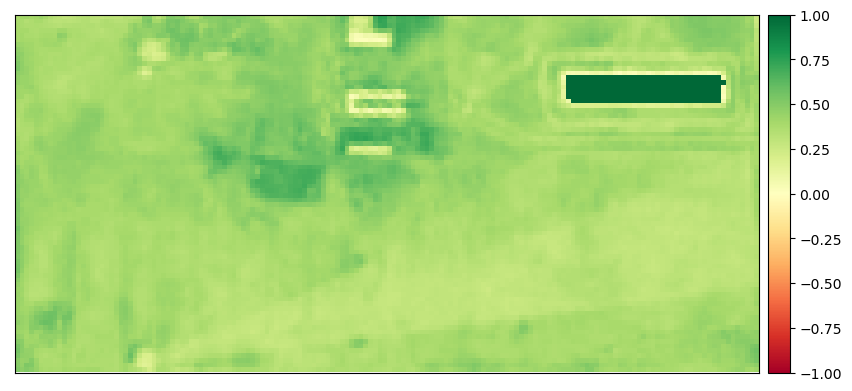

In [29]:
L = 0.5
savi = ((aoi_bands_stack[7] - aoi_bands_stack[3]) / (aoi_bands_stack[7] + aoi_bands_stack[3] + L)) * (1 + L)

ep.plot_bands(savi, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))
plt.show()

In [30]:
savi_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(savi, mask=mask.reshape(aoi_height, aoi_width))
    savi_masked_array.append(mx)

# Гистограмма SAVI по загонам

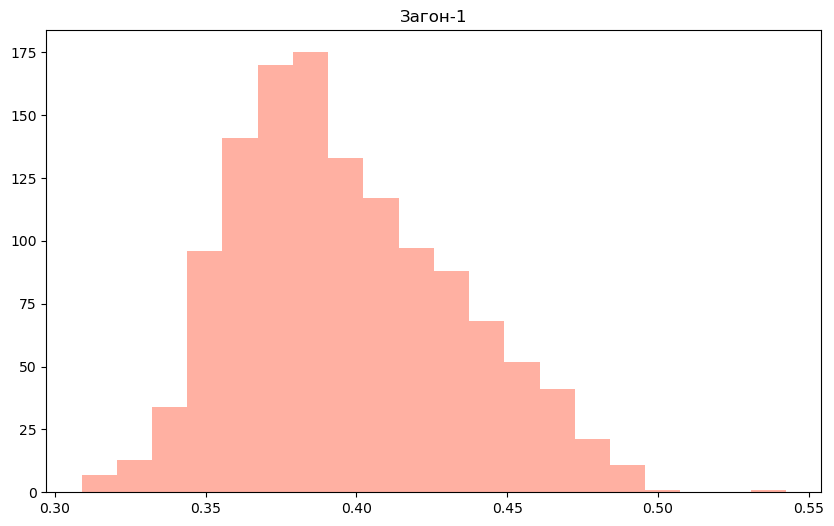

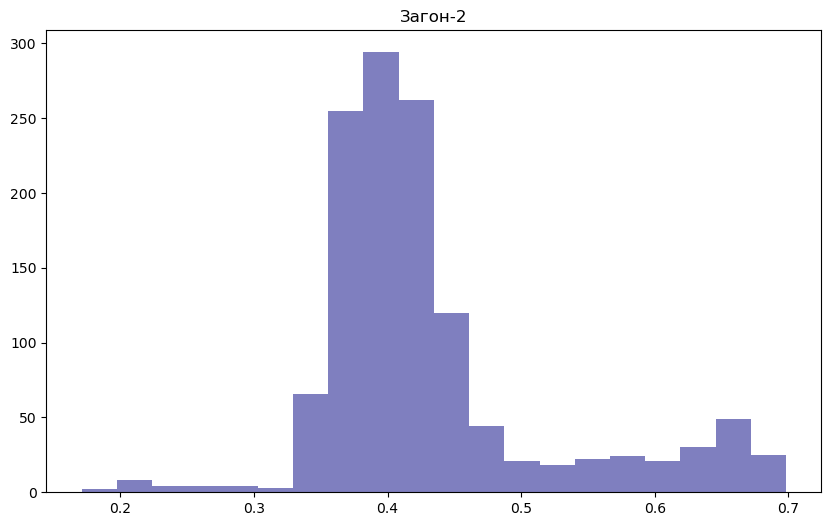

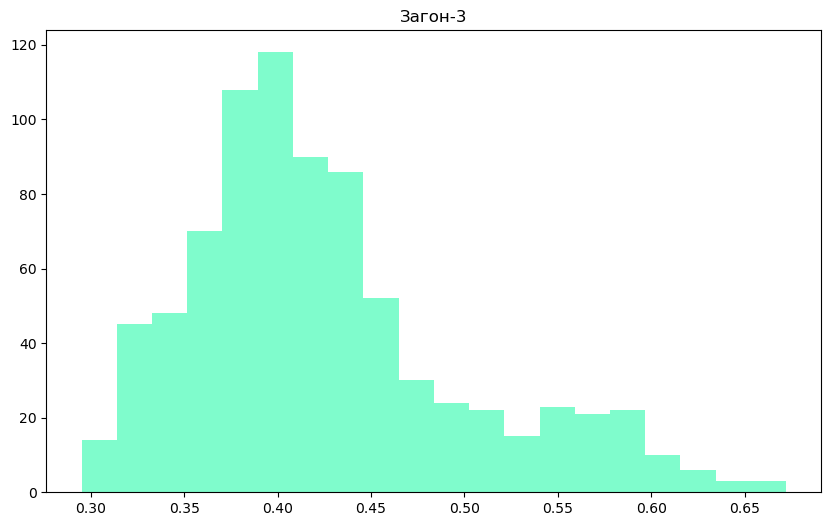

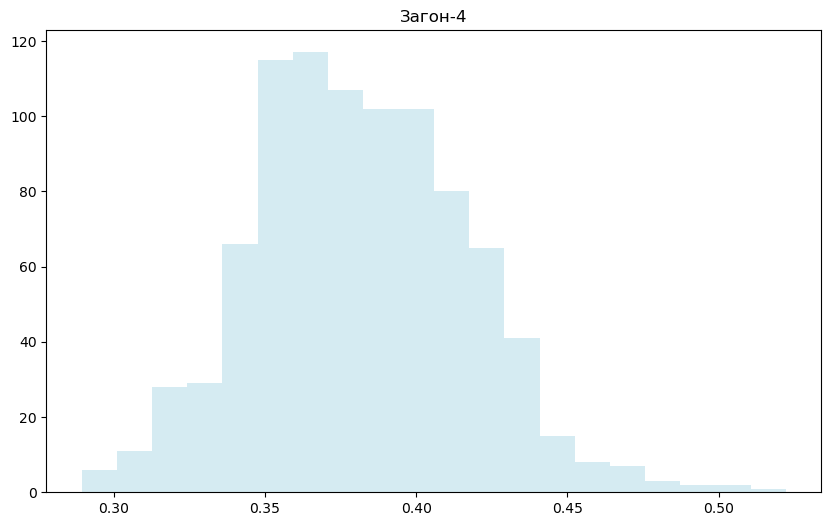

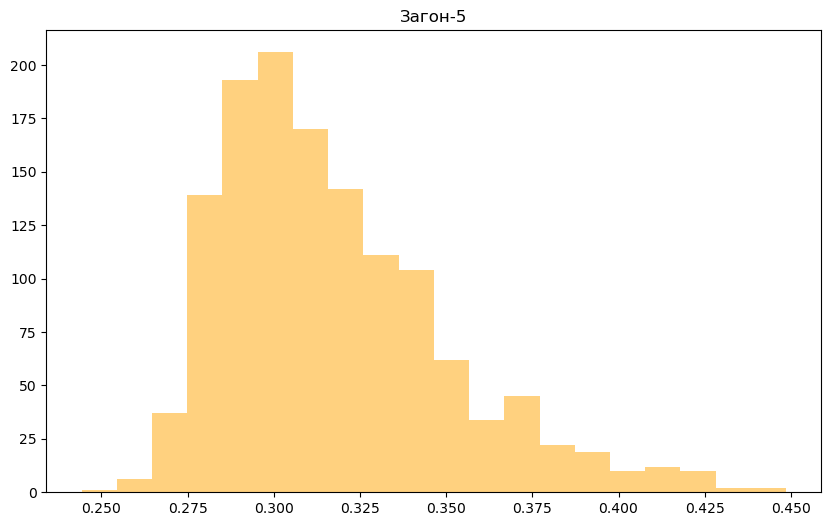

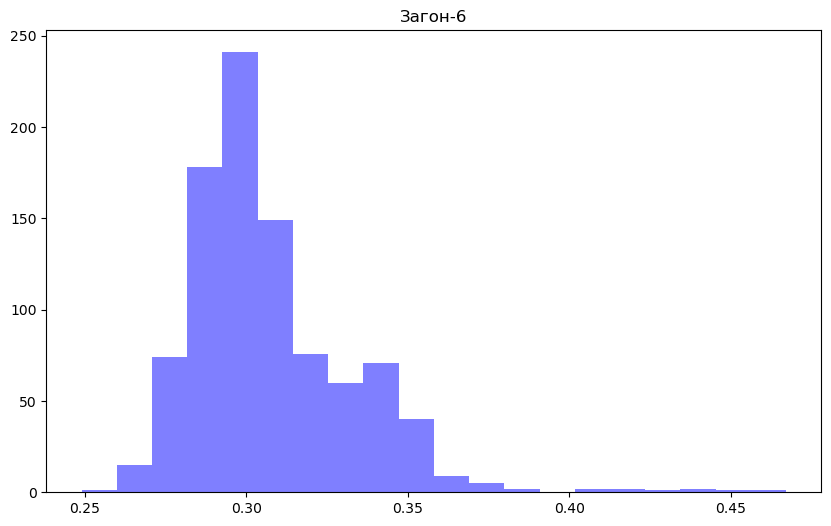

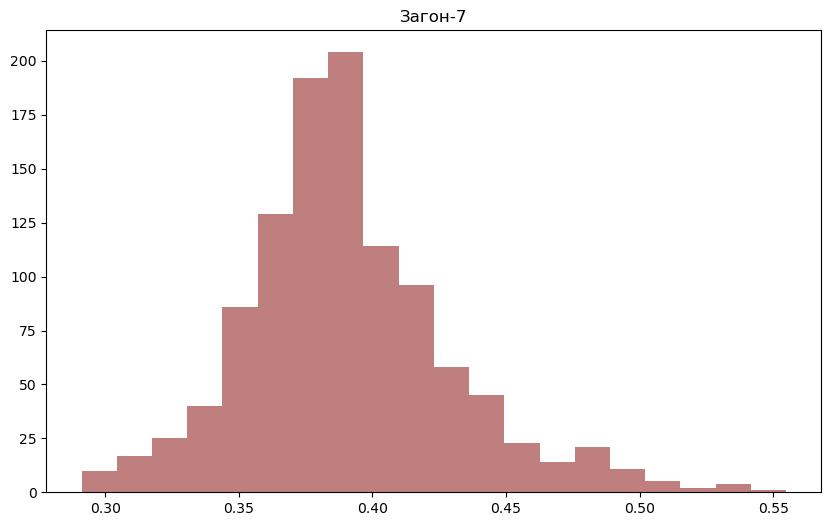

In [31]:
for i, zagon in enumerate(savi_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))

plt.show()

# Статистические средние значения по загонам 

In [32]:
for zagon in range(len(masks)):
    print(f"Загон №{zagon+1}. Среднее значение SAVI: ", savi_masked_array[zagon].mean())

Загон №1. Среднее значение SAVI:  0.3963725765207756
Загон №2. Среднее значение SAVI:  0.43201613224877017
Загон №3. Среднее значение SAVI:  0.42505506663638604
Загон №4. Среднее значение SAVI:  0.38166726829306086
Загон №5. Среднее значение SAVI:  0.3170871210146236
Загон №6. Среднее значение SAVI:  0.3073991535490293
Загон №7. Среднее значение SAVI:  0.3905360864075347


In [33]:
for zagon in range(len(masks)):
    print(f"Загон №{zagon+1}. Медианное значение SAVI: ", ma.median(savi_masked_array[zagon]))

Загон №1. Медианное значение SAVI:  0.39039225466297234
Загон №2. Медианное значение SAVI:  0.4081982252091705
Загон №3. Медианное значение SAVI:  0.4086776658005128
Загон №4. Медианное значение SAVI:  0.3797942001870907
Загон №5. Медианное значение SAVI:  0.3099160708734846
Загон №6. Медианное значение SAVI:  0.3013514314807031
Загон №7. Медианное значение SAVI:  0.3868157866437251


In [34]:
for zagon in range(len(masks)):
    print(f"Загон №{zagon+1}. Гармоническое среднее значение SAVI: ", hmean(savi_masked_array[zagon].reshape(aoi_width * aoi_height)))

Загон №1. Гармоническое среднее значение SAVI:  0.3930949486337637
Загон №2. Гармоническое среднее значение SAVI:  0.41644187215925055
Загон №3. Гармоническое среднее значение SAVI:  0.4135676642821309
Загон №4. Гармоническое среднее значение SAVI:  0.3784195590083429
Загон №5. Гармоническое среднее значение SAVI:  0.31401332899832946
Загон №6. Гармоническое среднее значение SAVI:  0.3055114089153174
Загон №7. Гармоническое среднее значение SAVI:  0.386823170167954


In [35]:
for zagon in range(len(masks)):
    print(f"Загон №{zagon+1}. Геометрическое среднее значение SAVI: ", gmean(savi_masked_array[zagon].reshape(aoi_width * aoi_height)))

Загон №1. Геометрическое среднее значение SAVI:  0.3947176502479228
Загон №2. Геометрическое среднее значение SAVI:  0.4239013406798329
Загон №3. Геометрическое среднее значение SAVI:  0.4191017751431186
Загон №4. Геометрическое среднее значение SAVI:  0.380039566857733
Загон №5. Геометрическое среднее значение SAVI:  0.31550829106310674
Загон №6. Геометрическое среднее значение SAVI:  0.3064256409190727
Загон №7. Геометрическое среднее значение SAVI:  0.3886593086637655


# Анализ полученных данных

In [36]:
analysis = pd.read_excel('excel_data.xlsx', 0)
analysis

,Урожай.,Проек. пок.,Выс. раст.,NDVI сред. знач.,NDVI мед. Знач.,NDVI гарм. сред.,NDVI геомет. сред.,SAVI сред. Знач.,SAVI мед. знач.,SAVI гарм. сред.,SAVI геомет. сред.
0,0.42,41.85,9.01,0.21590,0.20697,0.21293,0.21435,0.32382,0.31041,0.31936,0.32149
1,0.60,80.80,14.90,0.26223,0.25901,0.26011,0.26116,0.39330,0.38848,0.39013,0.39170


In [37]:
corr = analysis.corr(method='pearson', min_periods=2)
corr.style.background_gradient(cmap='coolwarm')

,Урожай.,Проек. пок.,Выс. раст.,NDVI сред. знач.,NDVI мед. Знач.,NDVI гарм. сред.,NDVI геомет. сред.,SAVI сред. Знач.,SAVI мед. знач.,SAVI гарм. сред.,SAVI геомет. сред.
Урожай.,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Проек. пок.,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Выс. раст.,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
NDVI сред. знач.,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
NDVI мед. Знач.,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
NDVI гарм. сред.,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
NDVI геомет. сред.,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
SAVI сред. Знач.,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
SAVI мед. знач.,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
SAVI гарм. сред.,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0, 0.5, 'Урожай')

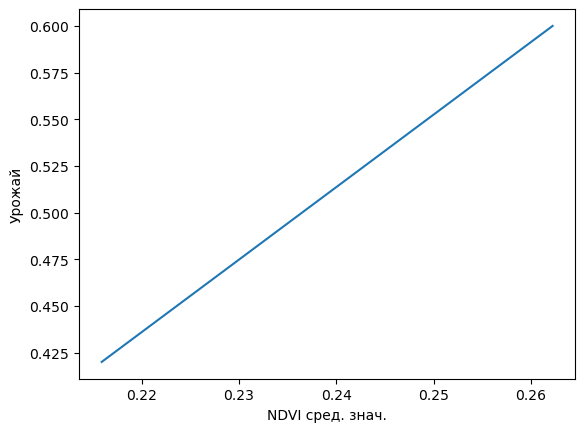

In [38]:
plt.plot(analysis["NDVI сред. знач."], analysis["Урожай."])

plt.xlabel("NDVI сред. знач.")
plt.ylabel("Урожай")

In [39]:
real = analysis.iloc[:, [0,1,2]]
dzz = analysis.iloc[:, [3,4,5,6,7,8,9,10]]

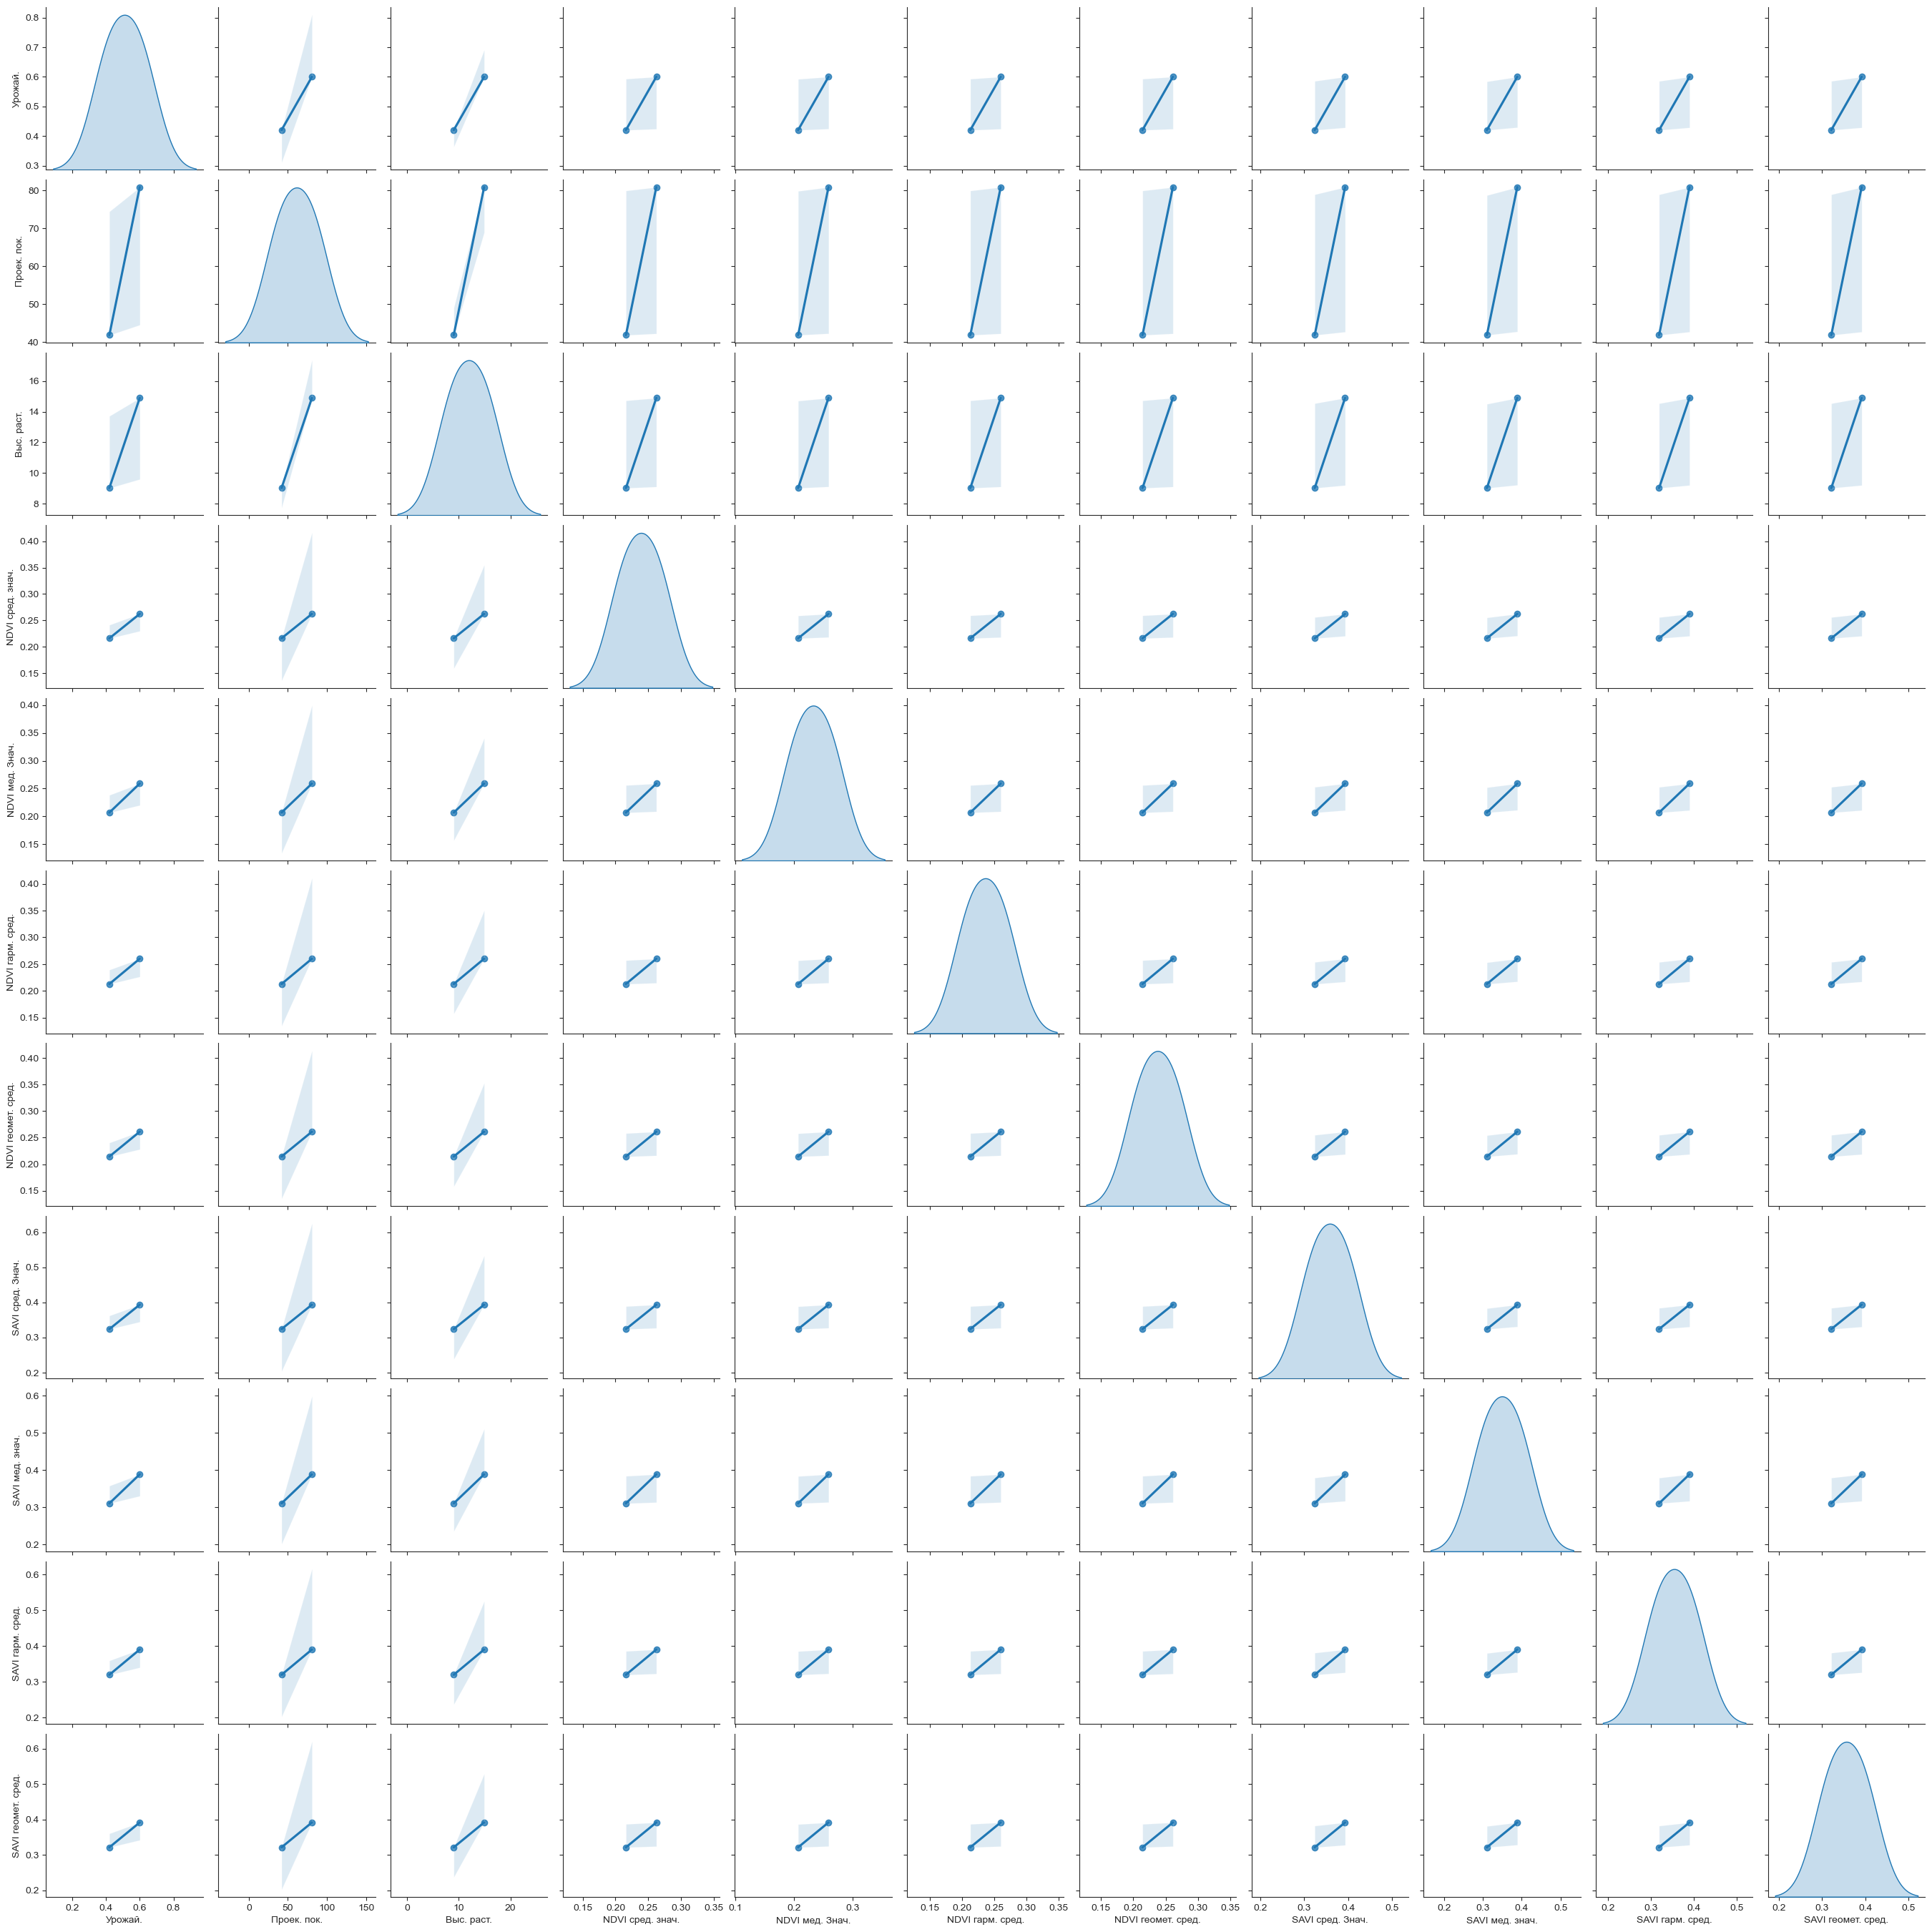

In [40]:
sns.set_style("ticks")
sns.pairplot(analysis, diag_kind = "kde", kind = "reg", palette = "husl")
plt.show()